In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
import cartopy.crs as ccrs
import os
from tqdm import tqdm

import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, Normalize
from multiprocess import Pool
import cartopy.feature as cfeature
## my own directory
os.chdir("/g/data/k10/dl6968/Semi-variogram_AU/")


In [2]:
params={     
    'axes.labelsize'  : '16',   
    'axes.titlesize'  : '16',  
    'xtick.labelsize' :'16',
    'ytick.labelsize' :'16',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [3]:
df = pd.read_csv("./data/BoM_daily_stations.csv")
exclude_stn = []
for stn_id in df["ID"]:
    bom_id = str(stn_id).zfill(6)
    if not os.path.exists(f'./data/all_AU_p90/{stn_id}_scale_list_all_events.csv'):
        exclude_stn.append(stn_id)
## mannually remove some faulty stations
df = df[~df["ID"].isin(exclude_stn)]

In [4]:
# Define seasons based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "DJF"
    elif month in [3, 4, 5]:
        return "MAM"
    elif month in [6, 7, 8]:
        return "JJA"
    elif month in [9, 10, 11]:
        return "SON"

In [5]:
season_dict = {}
for spec_id in tqdm(df["ID"],leave=True, position=0):
    df_scale = pd.read_csv(f"./data/all_AU_p90/{spec_id}_scale_list_all_events.csv")
    df_scale["Date"] = pd.to_datetime(df_scale["extreme_dates"])
    df_scale["Season"] = df_scale["Date"].apply(get_season)
    df_scale["scale"] = df_scale["scale"].replace(0, np.nan)

    seasons = {season: group["scale"].tolist() for season, group in df_scale.groupby("Season")}
    season_dict[str(spec_id)] = seasons

100%|██████████| 9842/9842 [01:25<00:00, 115.61it/s]


In [6]:
djf_mean = [np.nanmean(season_dict[str(spec_id)]["DJF"]) if "DJF" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
mam_mean = [np.nanmean(season_dict[str(spec_id)]["MAM"]) if "MAM" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
jja_mean = [np.nanmean(season_dict[str(spec_id)]["JJA"]) if "JJA" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
son_mean = [np.nanmean(season_dict[str(spec_id)]["SON"]) if "SON" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]


/jobfs/135766878.gadi-pbs/ipykernel_1741924/2957603743.py:1: RuntimeWarning: Mean of empty slice
  djf_mean = [np.nanmean(season_dict[str(spec_id)]["DJF"]) if "DJF" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
/jobfs/135766878.gadi-pbs/ipykernel_1741924/2957603743.py:2: RuntimeWarning: Mean of empty slice
  mam_mean = [np.nanmean(season_dict[str(spec_id)]["MAM"]) if "MAM" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
/jobfs/135766878.gadi-pbs/ipykernel_1741924/2957603743.py:3: RuntimeWarning: Mean of empty slice
  jja_mean = [np.nanmean(season_dict[str(spec_id)]["JJA"]) if "JJA" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
/jobfs/135766878.gadi-pbs/ipykernel_1741924/2957603743.py:4: RuntimeWarning: Mean of empty slice
  son_mean = [np.nanmean(season_dict[str(spec_id)]["SON"]) if "SON" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]


In [7]:
# Define color segments
colors = [
    (0, "brown"),    
    (0.3, "gold"), 
    (0.7, "lightblue"),
    (1, "royalblue")      
]

# Create custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)


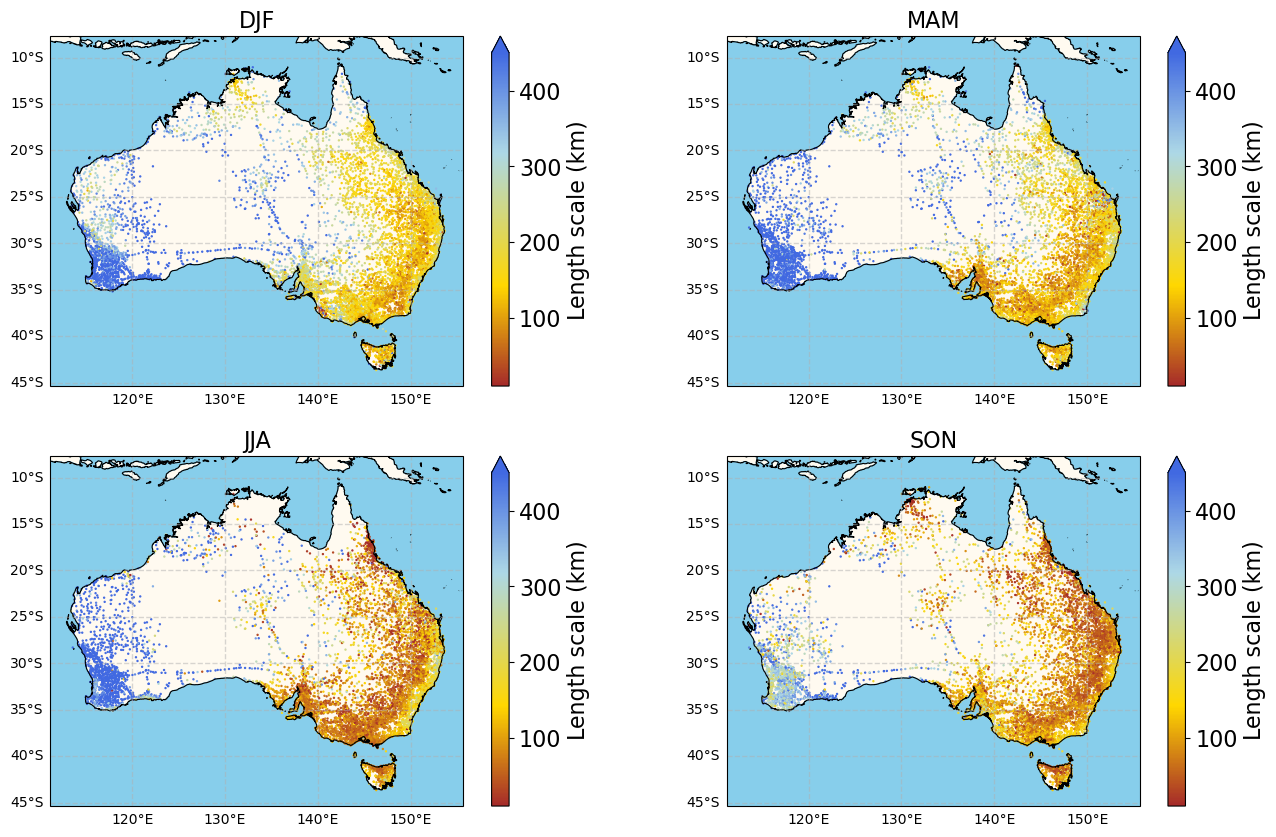

In [8]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree())
cmap = custom_cmap
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= djf_mean, cmap=cmap, vmin=10,vmax=450, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax1.coastlines('10m', color="black",linewidth=0.8)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_title("DJF")
ax1.add_feature(cfeature.LAND, color='floralwhite')  
ax1.add_feature(cfeature.OCEAN, color='skyblue')  

ax2 = fig.add_subplot(222, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= mam_mean, cmap=cmap, vmin=10,vmax=450, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax2.coastlines('10m', color="black",linewidth=0.8)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_title("MAM")
ax2.add_feature(cfeature.LAND, color='floralwhite')  
ax2.add_feature(cfeature.OCEAN, color='skyblue')  

ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= jja_mean, cmap=cmap, vmin=10,vmax=450,
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax3.coastlines('10m', color="black",linewidth=0.8)
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax3.set_title("JJA")
ax3.add_feature(cfeature.LAND, color='floralwhite')  
ax3.add_feature(cfeature.OCEAN, color='skyblue')  

ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= son_mean,  cmap=cmap, vmin=10,vmax=450,  
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax4.coastlines('10m', color="black",linewidth=0.8)
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax4.set_title("SON")
ax4.add_feature(cfeature.LAND, color='floralwhite')  
ax4.add_feature(cfeature.OCEAN, color='skyblue')  
plt.savefig("AU_seasonality.png", dpi=200, bbox_inches="tight")